In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from train import get_model_class
from util import convert_to_tensor
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa, top_k_cdc, top_k_consistency
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

/Users/leonard/opt/anaconda3/envs/cs282/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_sources = ['rs', 'loo']

In [3]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

### Compute and save predictions from models

In [6]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        pred = model.predict(X_test)
        np.save(f'{directory}/{random_source}_preds_{i}.npy', pred)

### Compute and save gradients from models

In [7]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        np.save(f'{directory}/{random_source}_grads_{i}.npy', grads)

### Path to Glory

In [4]:
# Ensemble sizes
ensemble_sizes = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20]

# Test point indices
test_idx = range(1000)
x = X_test[test_idx]

# Random source
random_source = random_sources[1]

# Number of ensembles to sample for each ensemble size
n_trials = 50

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

In [48]:
# Count variables
topk, signs, counts = [], [], []
counts_pos, counts_neg = [], []
topk_counts_signed, signs_counts_signed = [], []

# 'Average ensemble' variables (take mean of gradients across models)
topk_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# 'Norm-average ensemble' variables (normalize gradients to unit l2-norm for each model, then take mean)
topk_norm_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_norm_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# 'Average smooth ensemble' variables (for each model, add noise to weights and recompute gradients, take mean)
topk_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)
n_weight_perturbations = 100
sigma = 0.5
layer_str = 'network.0.weight'

# 'SmoothGrad' variables (for each model, introduce "noise" by sampling from neighborhood of input and compute gradients, take mean)
topk_smoothgrad = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_smoothgrad = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)
# TODO(Leonard): May want to rethink these. What is a fair comparison with smooth ensemble? Maybe should normalize with respect to # of params/features
# Original paper says (for images) that noise is dataset dependent. 10-20% is good for Inception on ImageNet. n > 50 sees diminishing returns 
# Noise % is sigma / (x_max - x_min)
# I think they calculate x_max, x_min only from the sample but will have to double check
# Or we can always just sweep params for both methods and compare.
# Too, we are adding normal noise on each input. Need to think about if should do this vs. normal noise over all inputs
n_smoothgrad_perturbations = 100
smoothgrad_sigma = 0.5

import time

for e, ensemble_size in tqdm(enumerate(ensemble_sizes)):
    tk = np.zeros((n_trials, ensemble_size, len(test_idx), k))
    s = np.zeros((n_trials, ensemble_size, len(test_idx), k), dtype=int)
    co = np.zeros((n_trials, len(test_idx), n_features))
    
    # Initialize count arrays
    co_pos = np.zeros((n_trials, len(test_idx), n_features))
    co_neg = np.zeros((n_trials, len(test_idx), n_features))

    for i in range(n_trials):
        
        # Sample models at random
        model_idx = np.random.choice(n_models, ensemble_size, replace=False)
        # Load saved gradients
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
        grads = grads[:, test_idx]
        
        average_start = time.time()
        # Compute 'average ensemble'
        tk[i], s[i] = get_top_k(k=k, X=grads, return_sign=True)
        topk_avg[e, i], signs_avg[e, i] = get_top_k(k=k, X=grads.mean(axis=0), return_sign=True)
        
        # Compute 'norm-average ensemble'
        norm_average_start = time.time()
        norm_grads = grads / np.linalg.norm(grads+1e-20, axis=2, keepdims=True)
        topk_norm_avg[e, i], signs_norm_avg[e, i] =\
            get_top_k(k=k, X=norm_grads.mean(axis=0), return_sign=True)
        
        # Smooth ensemble
        smooth_start = time.time()
        smooth_grads = np.zeros_like(grads)
        for j in range(ensemble_size):
            for _ in range(n_weight_perturbations):
                # Add noise to layer weights
                model = model_class(*model_args)
                state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
                state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
                model.load_state_dict(state_dict)

                # Compute new gradients
                smooth_grads[j] += model.compute_gradients(x, softmax=False, label=1, return_numpy=True)
        smooth_grads /= n_weight_perturbations

        topk_smooth[e, i], signs_smooth[e, i] =\
            get_top_k(k=k, X=smooth_grads.mean(axis=0), return_sign=True)
        
        # SmoothGrad
        smoothgrad_start = time.time()
        smoothgrad_grads = np.zeros_like(grads) 
        # Add noise to input features
        noise = np.random.normal(scale=smoothgrad_sigma, size=(n_smoothgrad_perturbations, x.shape[0], x.shape[1]))
        noisy_x = np.vstack([np.expand_dims(x, axis=0)] * n_smoothgrad_perturbations) + noise

        for j in range(ensemble_size):
            model = model_class(*model_args)
            state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
            model.load_state_dict(state_dict)
            # Average gradient across inputs
            smoothgrad_grads[j] = model.compute_gradients(noisy_x, softmax=False, label=1, return_numpy=True).mean()

        # Get top k based on ensembled (average) model, where each model is a SmoothGrad model
        topk_smoothgrad[e, i], signs_smoothgrad[e, i] =\
            get_top_k(k=k, X=smoothgrad_grads.mean(axis=0), return_sign=True)
    
        # Compute counts
        compute_start = time.time()
        for t_i in range(len(test_idx)):
            # Unique indices and their counts
            u, c = np.unique(tk[i, :, t_i].flatten(), return_counts=True)
            co[i, t_i, u.astype(int)] = c
            for j in range(ensemble_size):
                for l in range(k):
                    feature_idx = tk[i, j, t_i, l].astype(int)
                    feature_sign = s[i, j, t_i, l]

                    if feature_sign > 0:
                        co_pos[i, t_i, feature_idx] += 1
                    elif feature_sign < 0:
                        co_neg[i, t_i, feature_idx] += 1

    tk_co_s, s_co_s = get_top_k(k, co_pos-co_neg, return_sign=True)
    
    # Append to lists
    topk.append(tk)
    signs.append(s)
    counts.append(co)
    counts_pos.append(co_pos)
    counts_neg.append(co_neg)
    topk_counts_signed.append(tk_co_s)
    signs_counts_signed.append(s_co_s)

0it [00:00, ?it/s]

Ensemble Size: 2
Compute 'average ensemble' took 0.002556324005126953 sec
Compute 'norm-average ensemble' took 0.0012998580932617188 sec
Compute 'smooth ensemble' took 0.5621011257171631 sec
Compute 'SmoothGrad ensemble' took 0.31175804138183594 sec
Compute 'counts' took 0.05014920234680176 sec
Compute 'average ensemble' took 0.001463174819946289 sec
Compute 'norm-average ensemble' took 0.0006661415100097656 sec
Compute 'smooth ensemble' took 0.5826361179351807 sec
Compute 'SmoothGrad ensemble' took 0.32518911361694336 sec
Compute 'counts' took 0.05442500114440918 sec
Compute 'average ensemble' took 0.0016911029815673828 sec
Compute 'norm-average ensemble' took 0.0008189678192138672 sec
Compute 'smooth ensemble' took 0.5053510665893555 sec
Compute 'SmoothGrad ensemble' took 0.303178071975708 sec
Compute 'counts' took 0.052854061126708984 sec
Compute 'average ensemble' took 0.003016948699951172 sec
Compute 'norm-average ensemble' took 0.0007889270782470703 sec
Compute 'smooth ensemble' 

0it [00:09, ?it/s]


KeyboardInterrupt: 

### Plot Metrics (need to adjust similarity_metrics.py to suit our uses)

In [32]:
# Count-based
SA = np.zeros((len(ensemble_sizes), len(test_idx)))
#consistencies = np.zeros((len(counts), len(test_idx)))
#CDC = np.zeros((len(counts), len(test_idx)))
#SSA = np.zeros((len(counts), len(test_idx)))

# Average/norm-average/smooth ensemble
SA_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_norm_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_smoothgrad = np.zeros((len(ensemble_sizes), len(test_idx)))

for i in tqdm(range(len(ensemble_sizes))):
    # Counting-based feature attributions
    tk_count = topk_counts_signed[i]
    sign_count = signs_counts_signed[i]
    #consistencies[i] = top_k_consistency(tk_count)
    #CDC[i] = average_pairwise_score(tk_count, sign_count, top_k_cdc)

    # Compute Signed-Agreement
    SA[i] = average_pairwise_score(tk_count, sign_count, top_k_sa)
    SA_avg[i] = average_pairwise_score(topk_avg[i], signs_avg[i], top_k_sa)
    SA_norm_avg[i] = average_pairwise_score(topk_norm_avg[i], signs_norm_avg[i], top_k_sa)
    SA_smooth[i] = average_pairwise_score(topk_smooth[i], signs_smooth[i], top_k_sa)
    SA_smoothgrad[i] = average_pairwise_score(topk_smoothgrad[i], signs_smoothgrad[i], top_k_sa)

100%|██████████| 10/10 [20:36<00:00, 123.67s/it]


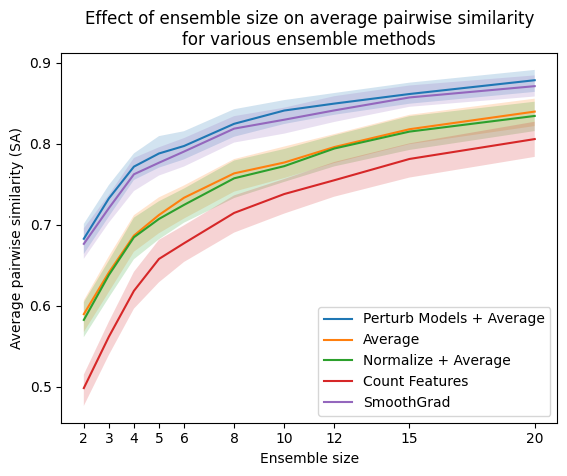

In [35]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features', 'SmoothGrad']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA, SA_smoothgrad]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

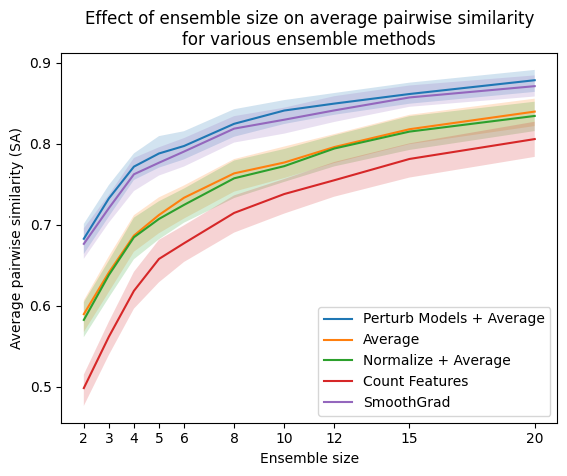

In [34]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features', 'SmoothGrad']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA, SA_smoothgrad]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

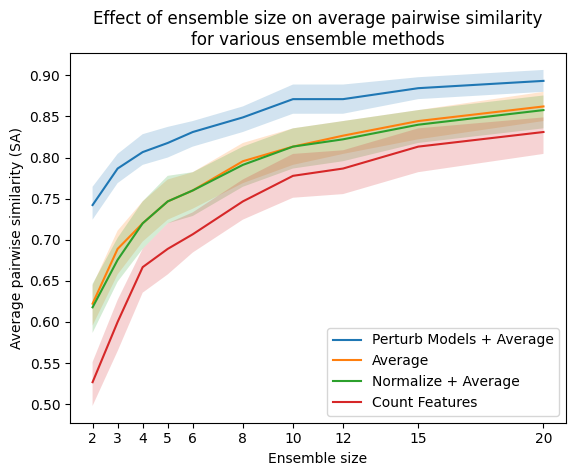

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

In [95]:
n_singles = [10, 20, 30, 40, 50]
sa_single = np.zeros((len(n_singles), len(test_idx)))
for i, n_single in tqdm(enumerate(n_singles)):
    grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(n_single)])
    grads = grads[:, test_idx]
    tk_single, s_single = get_top_k(k, grads, return_sign=True)
    sa_single[i] = average_pairwise_score(tk_single, s_single, top_k_sa)

5it [00:17,  3.43s/it]


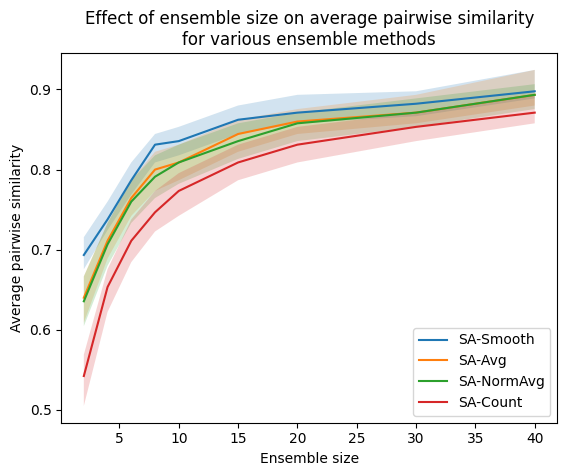

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

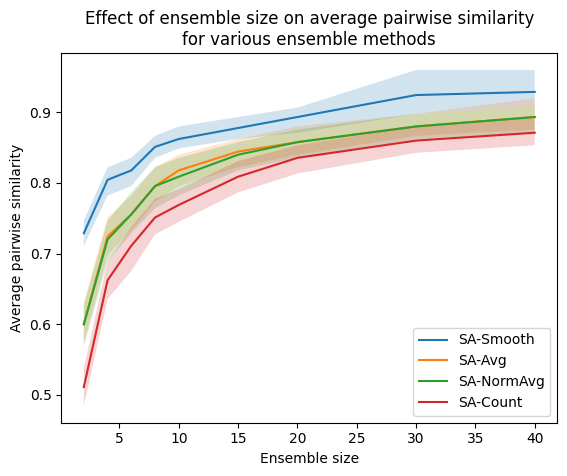

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

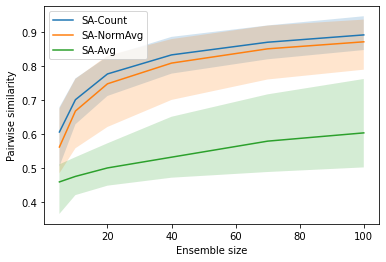

In [ ]:
titles = ['SA-Count', 'SA-NormAvg', 'SA-Avg']
for i, metric in enumerate([SA, SA_norm_avg, SA_avg]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

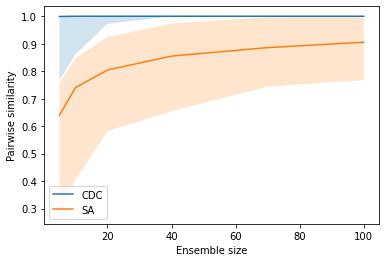

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.1, 0.5, 0.9], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

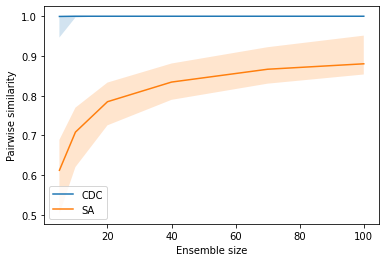

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

In [305]:
# 1 row, no. metrics columns
# metrics: consistency, SA, CDC, SSA
metrics = [consistencies, SA, CDC, SSA]

(6, 100)

### Misc Plots

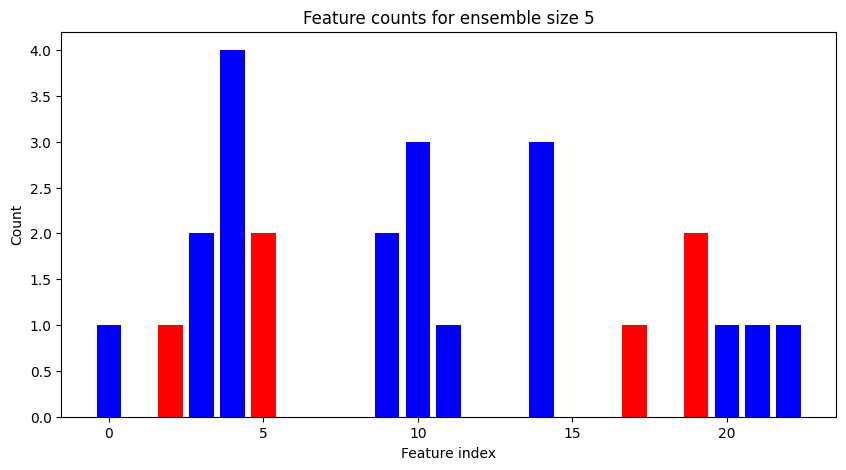

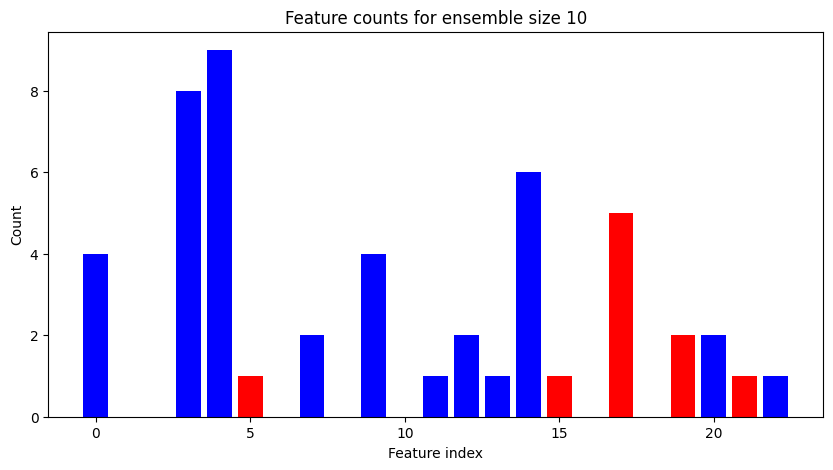

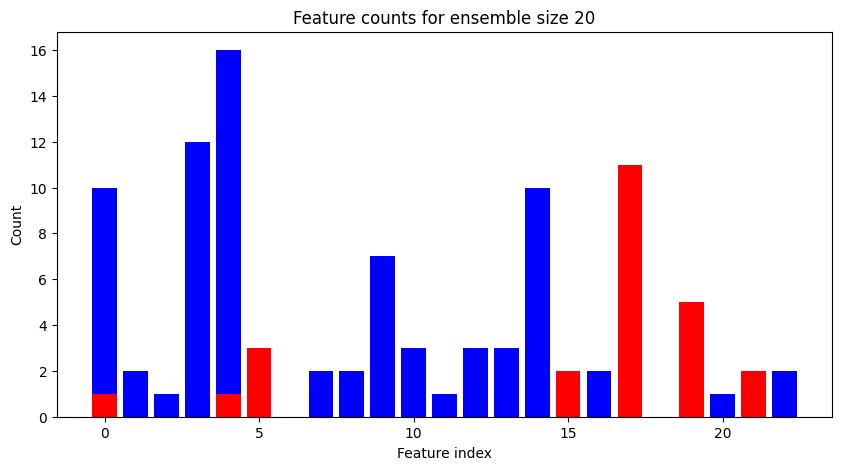

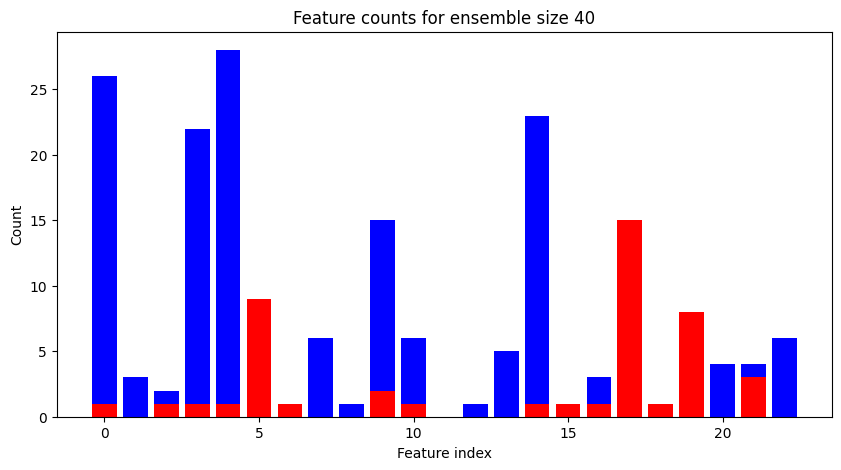

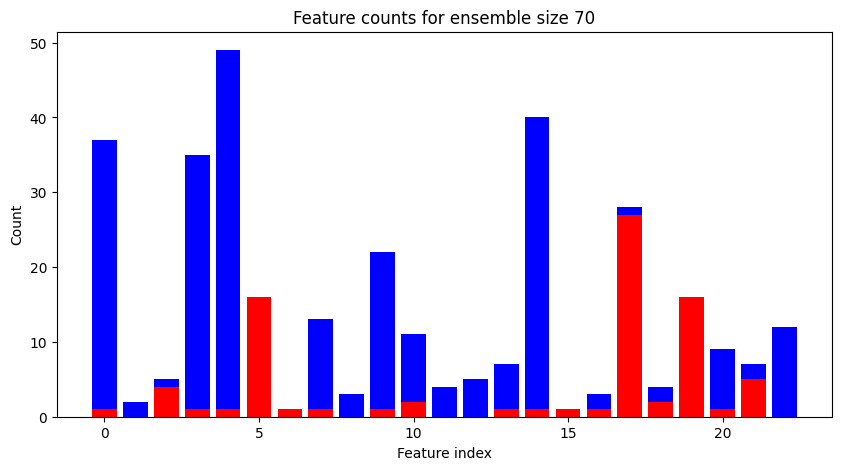

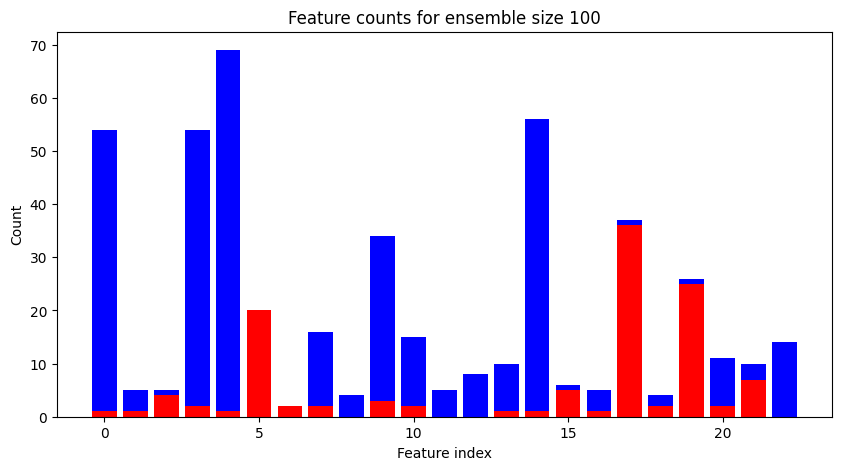

In [304]:
for i, ensemble_size in enumerate(ensemble_sizes):
    p, n = counts_pos[i][0,0], counts_neg[i][0,0]
    # Plot bar chart of feature counts, with positive and negative counts stacked
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_features), p + n, color='blue')
    plt.bar(range(n_features), n, color='red')
    plt.title(f'Feature counts for ensemble size {ensemble_size}')
    plt.xlabel('Feature index')
    plt.ylabel('Count')
    plt.show()

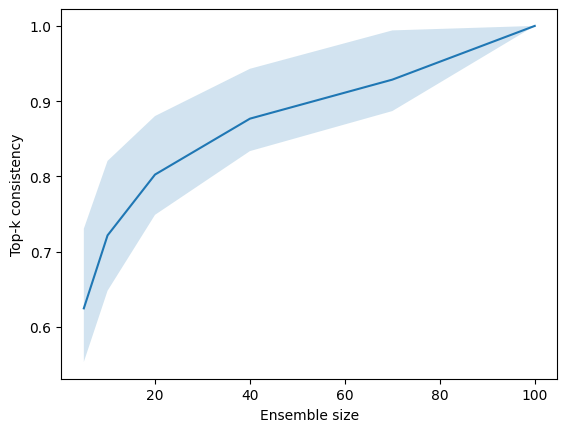

In [256]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

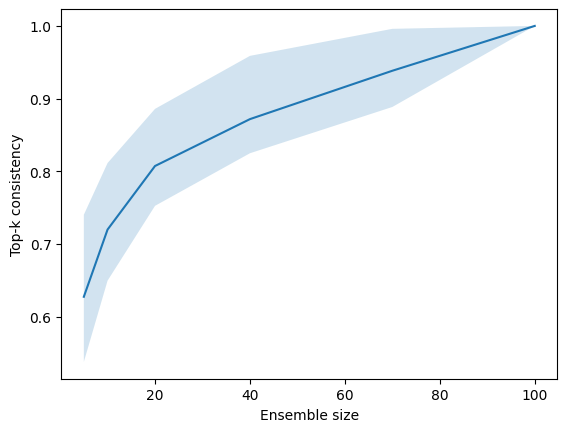

In [ ]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

### How to load/visualize gradients

In [44]:
# Set ensemble size
size_ensemble = 10

In [45]:
# Randomly sample size_ensemble indices from 0 to n_models
indices = np.random.choice(n_models, size_ensemble, replace=False)
indices

array([ 5, 11, 15, 49, 41, 93,  7, 52, 96, 69])

In [46]:
# Load predictions and gradients for models with those indices
preds = np.array([np.load(f'{directory}/{random_source}_preds_{i}.npy') for i in indices])
grads = np.array([np.load(f'{directory}/{random_source}_grads_{i}.npy') for i in indices])

In [47]:
# grads has size (size_ensemble, n_inputs, n_features) for tabular data
n_inputs, n_features = grads.shape[1:]
n_inputs, n_features

(1975, 23)

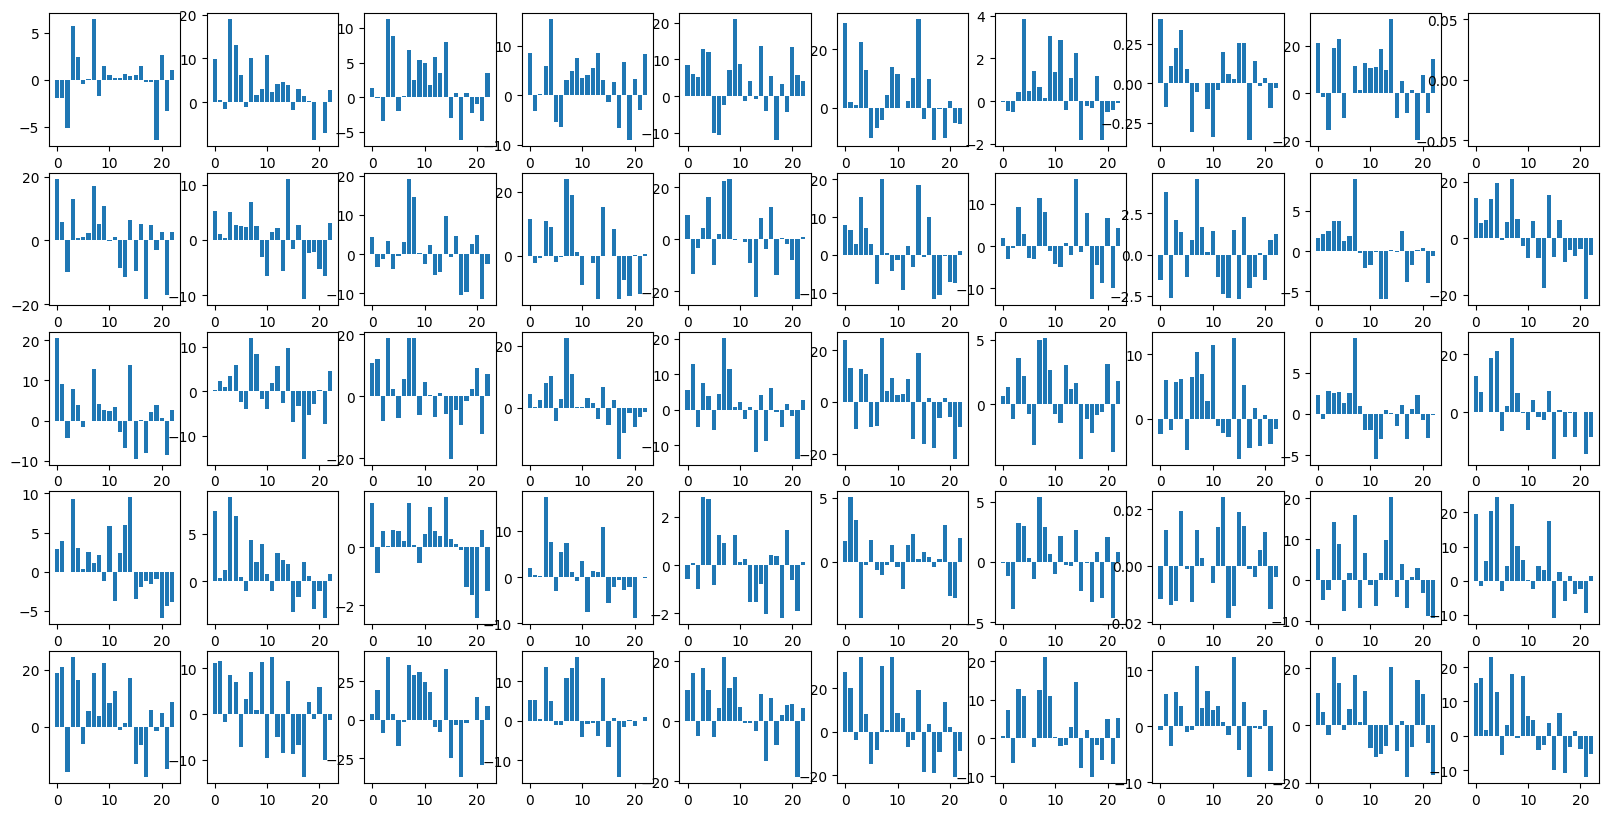

In [48]:
# Visualize gradients for each of the models in the ensemble for first 5 inputs
# Rows are inputs, columns are models
rows = 5
fig, axs = plt.subplots(rows, size_ensemble, figsize=(rows*4, size_ensemble), dpi=100)
for i in range(5):
    for j in range(size_ensemble):
        axs[i,j].bar(range(n_features), grads[j,i])
plt.show()

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller

### Top k and comparisons

In [40]:
print("(no. models in ensemble, no. test inputs, no. features)")
print(grads.shape)

(no. models in ensemble, no. test inputs, no. features)
(10, 1975, 23)


In [41]:
from similarity_metrics import get_top_k

In [53]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
grads.shape

(100, 1975, 23)

In [54]:
from tqdm import tqdm

In [155]:
from similarity_metrics import get_top_k

In [158]:
tk, s = get_top_k(k=5, X=grads, return_sign=True)

In [161]:
grads.shape

(100, 10, 23)

In [163]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
grads = grads[:, test_idx]
grads.shape

(100, 10, 23)

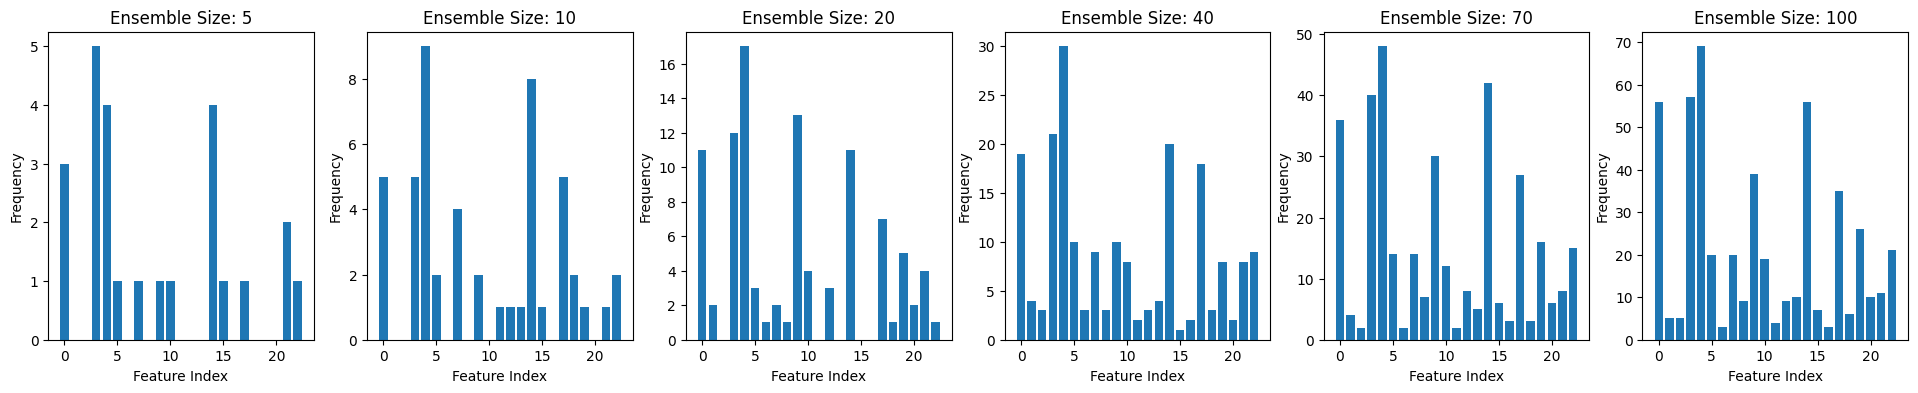

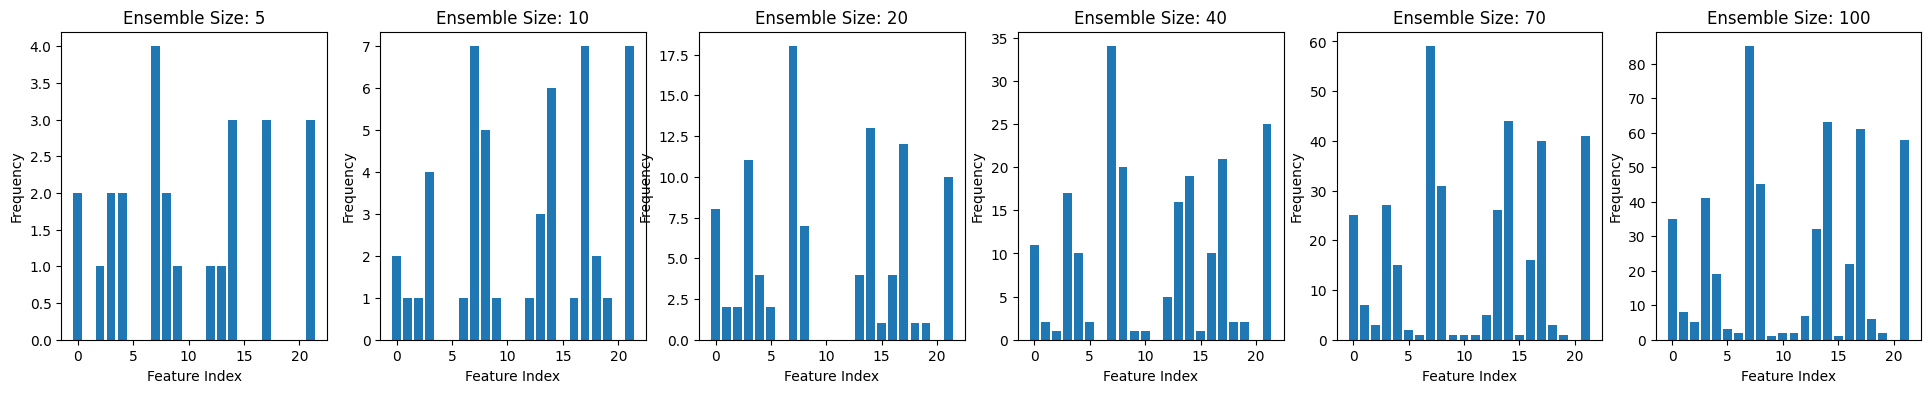

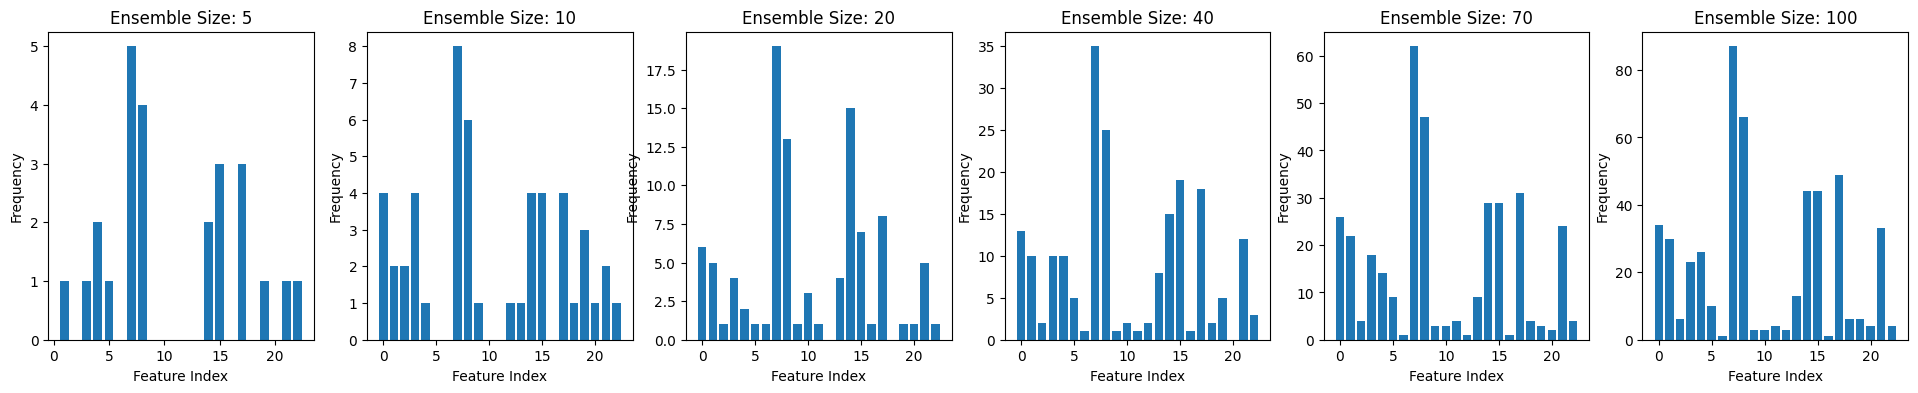

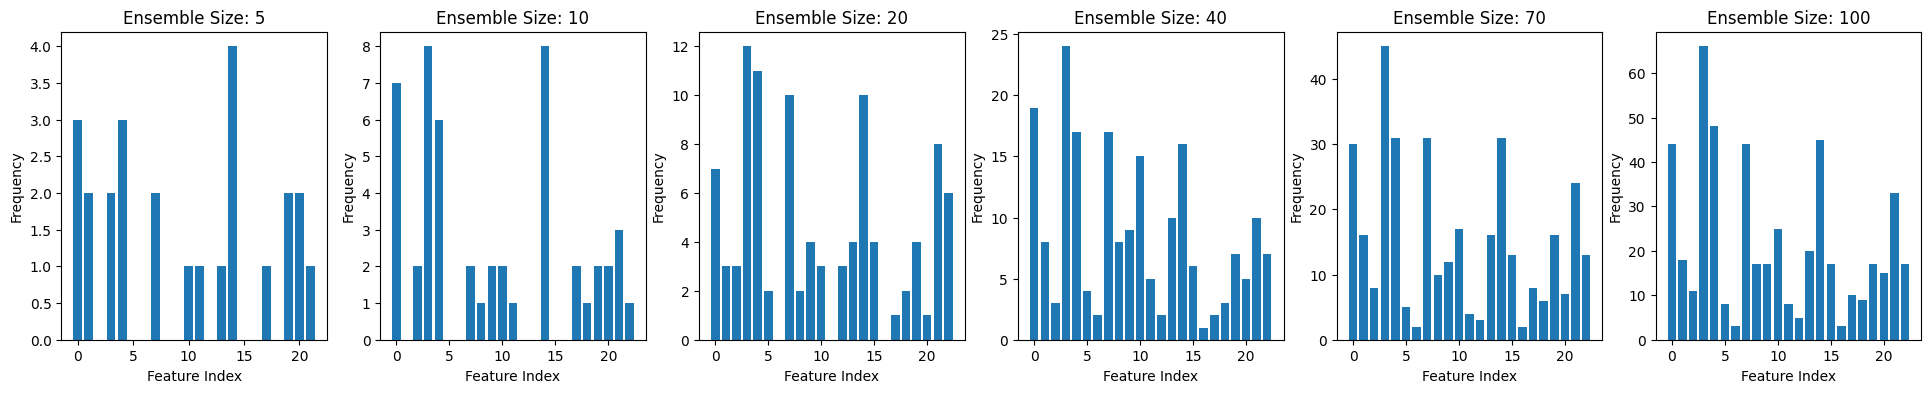

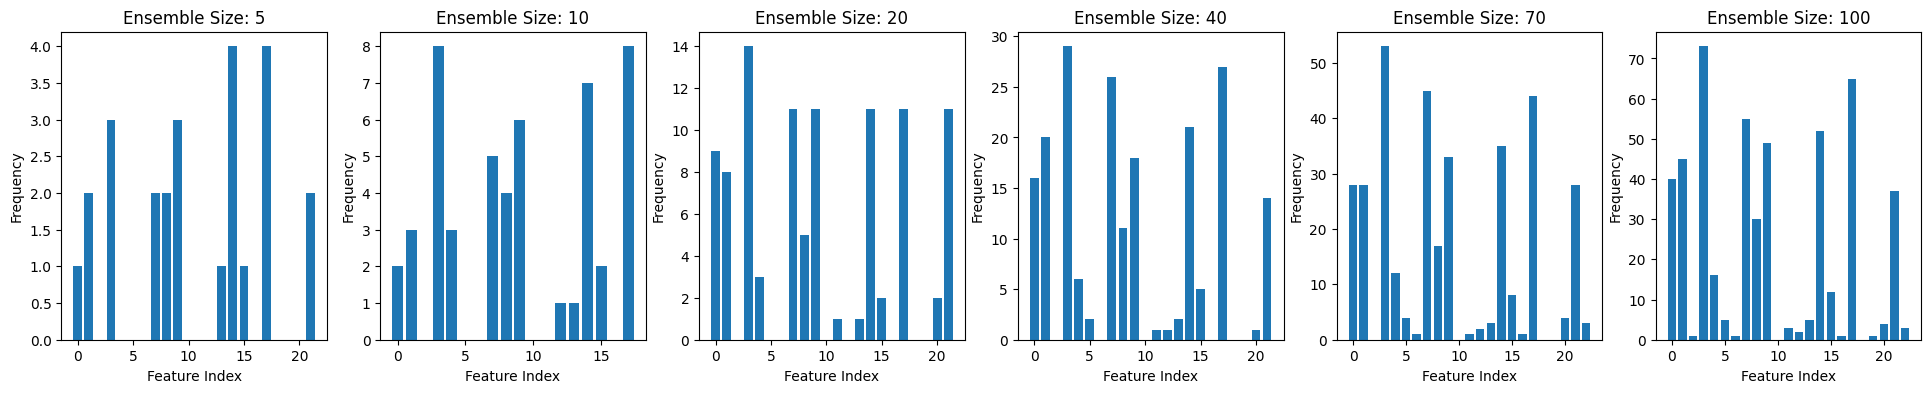

In [49]:
ensemble_sizes = [5, 10, 20, 40, 70, 100]
# Randomly sample size_ensemble indices from 0 to n_models for each ensemble size, load grads, and get top k grads
top5 = []
n_test = 5
counts = np.zeros((n_test, len(ensemble_sizes), n_features))
for i in range(n_test):
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(len(ensemble_sizes)*4, 4), dpi=100)
    for j, size_ensemble in enumerate(ensemble_sizes):
        indices = np.random.choice(n_models, size_ensemble, replace=False)  # should do this many times
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
        top5.append(np.array([get_top_k(grads[idx], k=5) for idx in range(size_ensemble)]))
        un, co = np.unique(top5[j][:, i].flatten(), return_counts=True)
        axs[j].bar(un, co)
        axs[j].set_xlabel('Feature Index')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(f'Ensemble Size: {size_ensemble}')
        counts[i, j, un] = co
    plt.show()

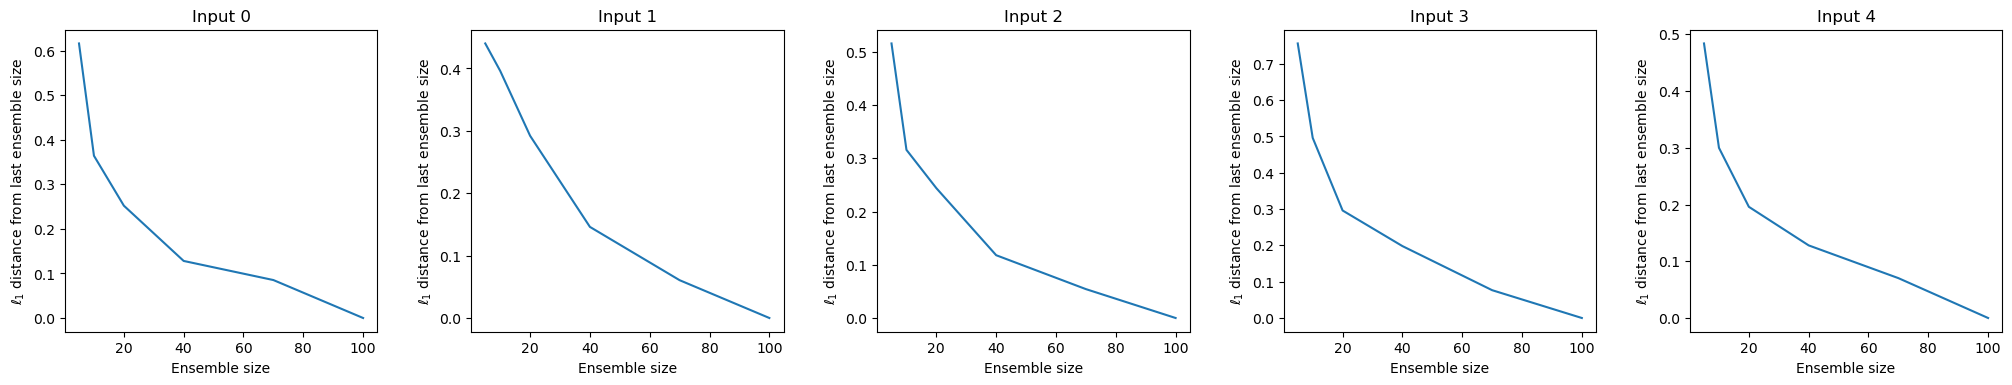

In [41]:
fig, axs = plt.subplots(1, n_test, figsize=(n_test*5, 4), dpi=100)
plt.subplots_adjust(wspace=0.3)
for i in range(n_test):
    counts_norm = counts[i]/np.sum(counts[i], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, np.linalg.norm(counts_norm-counts_norm[-1], axis=1, ord=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('$\ell_1$ distance from last ensemble size')
    axs[i].set_title(f'Input {i}')
plt.show()

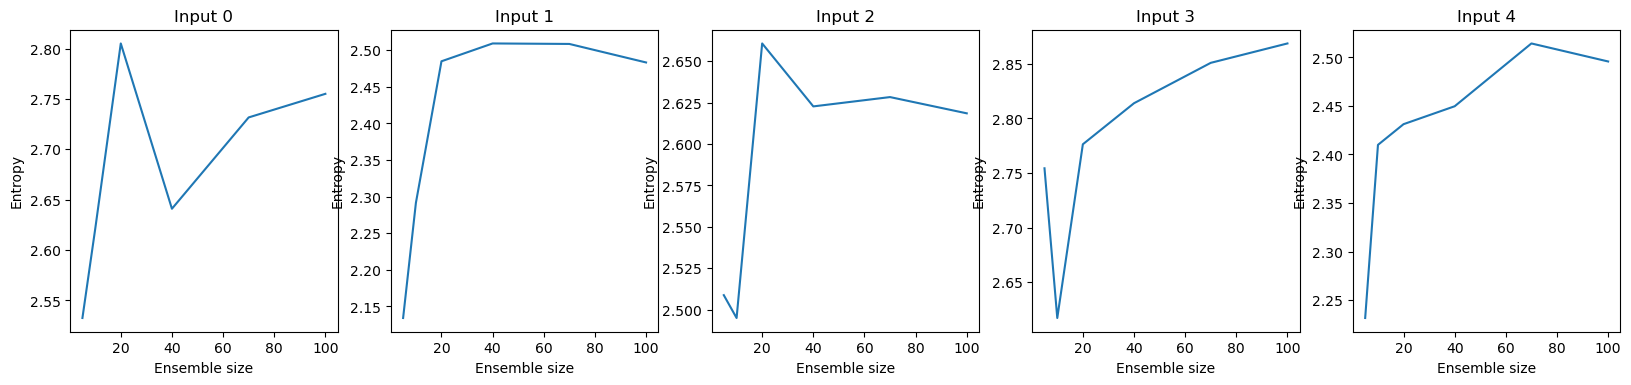

In [20]:
# Compute entropy of each feature distribution in counts
from scipy.stats import entropy
# Plot entropy of counts for each input
fig, axs = plt.subplots(1, n_test, figsize=(n_test*4, 4), dpi=100)
for i in range(n_test):
    full_counts_norm = counts[i, -1]/np.sum(counts[i, -1])
    counts[0]/np.sum(counts[0], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, entropy(counts[i], axis=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'Input {i}')
plt.show()

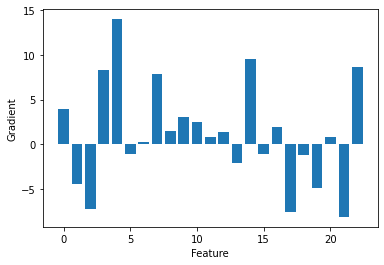

In [65]:
# Function for a single gradient plot
def plot_grad(grad, k=-1):
    # Optional top k gradients by absolute value
    if k > 0:
        grad = grad[np.argsort(np.abs(grad))[-k:]]
    plt.bar(range(grad.shape[0]), grad)
    plt.ylabel('Gradient')
    plt.xlabel('Feature')
    plt.show()

plot_grad(grads[0,0])